In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import model_selection, feature_selection, ensemble, linear_model, metrics
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn_relief as relief
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential
import pickle, os, joblib
import time
from PyImpetus import PPIMBR

2022-12-12 15:38:08.157438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_excel("testDatasetExample.xls") #change the filepath with the correct test dataset
IDs = df['ID']
df.drop('ID', axis=1, inplace=True)
#df= df.rename(columns={"RelapseFreeSurvival (outcome)":"Y_reg", "pCR (outcome)":"Y_clf"}) 
df.head()

,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,56.881588,0,0,0,1,3,3,999,0,2,...,0.194591,0.194591,2.846439,0.001281,4.168474e+06,131.044541,0.002335,0.109755,0.013383,0.002051
1,60.000000,0,0,1,0,2,1,1,0,3,...,0.309999,0.309996,2.975317,0.007253,1.736585e+05,23.967478,0.011285,0.055890,0.003163,0.009553
2,58.234086,0,0,0,1,3,3,1,1,4,...,0.328377,0.328377,3.785966,0.003185,3.607821e+06,223.279556,0.001334,0.101628,0.010844,0.001194


---
# Missing value dealing

In [3]:
df = df.replace(999,np.nan)
df.columns[df.isna().any()].tolist()

['HistologyType']

0


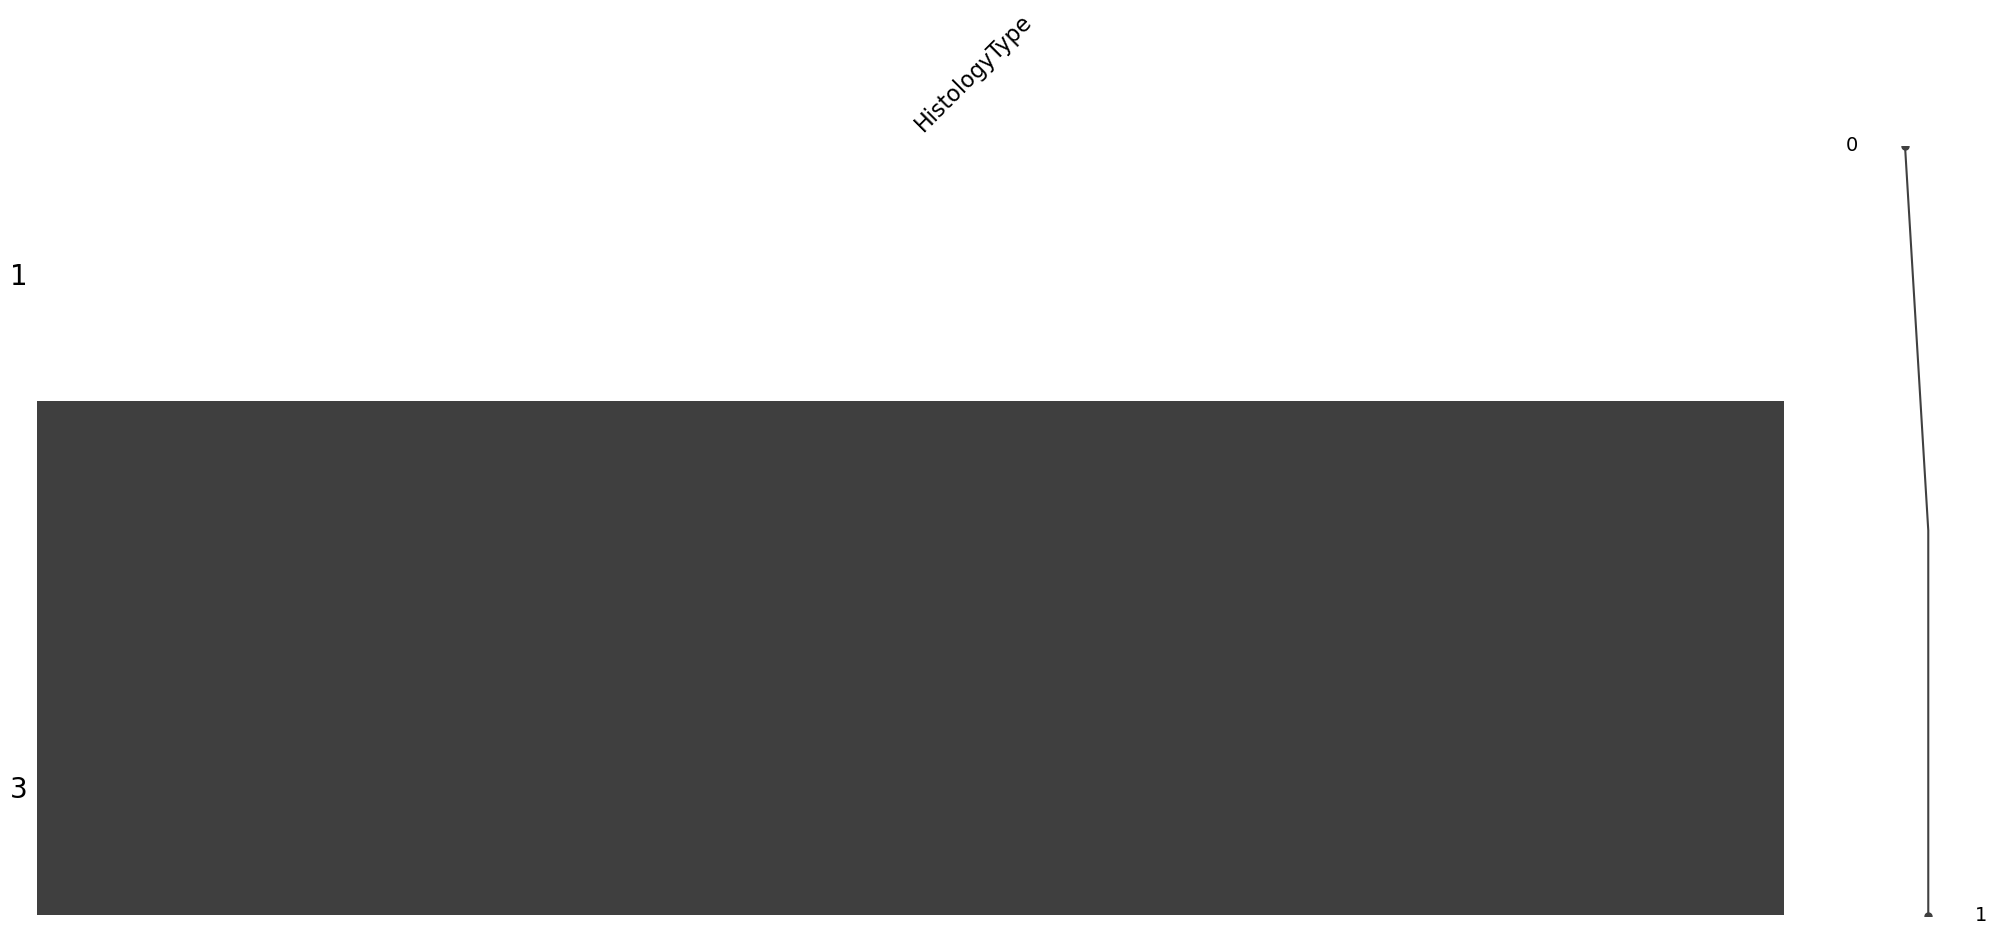

In [4]:
import missingno as msno
null_cols = df.columns[df.isnull().any()]
msno.matrix(df[null_cols])

#knn imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)

result = imputer.fit_transform(df)
nonNulldataFrame = pd.DataFrame(result, columns= df.columns.tolist())
nonNulldataFrame = nonNulldataFrame[null_cols].apply(lambda x: round(x))
df = df.drop(null_cols, axis=1)
df = pd.concat([df, nonNulldataFrame], axis=1)
#checking for missing
#nonNulldataFrame.to_csv("test.csv")
print(nonNulldataFrame.isnull().sum().sum())

In [5]:
df.head()

,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,LNStatus,TumourStage,original_shape_Elongation,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,HistologyType
0,56.881588,0,0,0,1,3,3,0,2,0.621404,...,0.194591,2.846439,0.001281,4.168474e+06,131.044541,0.002335,0.109755,0.013383,0.002051,1.0
1,60.000000,0,0,1,0,2,1,0,3,0.733284,...,0.309996,2.975317,0.007253,1.736585e+05,23.967478,0.011285,0.055890,0.003163,0.009553,1.0
2,58.234086,0,0,0,1,3,3,1,4,0.703667,...,0.328377,3.785966,0.003185,3.607821e+06,223.279556,0.001334,0.101628,0.010844,0.001194,1.0


---
# Normalisation using MinMaxScaler

In [6]:
## MinMaxscaler for non-categorical features
cols = ['ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
df_num = df.drop(cols, axis=1)
scalar = MinMaxScaler((0,1))
df_cols = df_num.columns.tolist()
scaled_data = pd.DataFrame(scalar.fit_transform(df_num), columns=df_cols)

df_pca = pd.concat([df[cols], scaled_data], axis=1)
df_pca

,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,Age,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,0,0,1,3,3,1.0,0,2,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.537233,0.100634,1.000000,1.000000,0.102585
1,0,0,1,0,2,1,1.0,0,3,1.000000,...,0.862628,0.862609,0.137173,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
2,0,0,0,1,3,3,1.0,1,4,0.433714,...,1.000000,1.000000,1.000000,0.318752,0.859655,1.000000,0.000000,0.849132,0.751574,0.000000


In [7]:
#selected features
markov_cols = ['original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_firstorder_Mean', 
'original_firstorder_Maximum', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 
'original_shape_Maximum2DDiameterColumn', 'original_firstorder_Range', 'original_firstorder_MeanAbsoluteDeviation', 
'original_glcm_DifferenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_shape_LeastAxisLength', 'original_firstorder_Kurtosis', 
'original_firstorder_10Percentile', 'original_shape_Maximum2DDiameterRow', 'original_glrlm_LongRunHighGrayLevelEmphasis', 
'original_shape_MeshVolume', 'HistologyType', 'original_firstorder_Variance', 'original_glrlm_LongRunLowGrayLevelEmphasis']

print(len(markov_cols))

#get the training set
X = df_pca[markov_cols].values

#load trained model
model = joblib.load('SVMreg_nested_markov_dt.pkl')
#predict the output
prediction = model.predict(X)
prediction

20


array([61.3623798 , 56.30877197, 57.15929834])

In [8]:
#write output into csv file
output_df = pd.DataFrame({'ID':IDs.values, 'predicted RFS (outcome)':prediction})
output_df
output_df.to_csv('Output_RFS.csv', index=False)